In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.utils as util

from sklearn import ensemble
from sklearn.metrics import mean_squared_error

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Decision tree

In [2]:
# Calculate impurity in node
def node_impurity(y):
    
    mean = np.mean(y)
    delta = np.subtract(y, mean)
    return np.dot(delta, delta)

# Calculate normalized impurity in node
def node_impurity_norm(y):

    return node_impurity(y) / float(len(y))

# Find impurity after splitting
def impurity_after_split(y, i):

    l_samples = y[:i]
    r_samples = y[i:]
    N_l = i
    N_r = len(y) - i
    
    return N_l * node_impurity_norm(l_samples) + N_r * node_impurity_norm(r_samples)

# Find best split for node
def find_split(node):
    
    new_impurity = +inf
    min_impurity = +inf
    feature = None
    threshold = None
    l_rows = None
    r_rows = None
    
    for j in xrange(node.X.shape[1]):
        x_column = node.X[:, j]
        rows = np.argsort(x_column)
        x_sorted = x_column[rows]
        y_sorted = node.Y[rows]
        
        for i in xrange(1, len(x_sorted)):   
            
            if x_sorted[i] == x_sorted[i - 1]:
                continue
                
            new_impurity = impurity_after_split(y_sorted, i)
            
            if new_impurity < min_impurity:
                min_impurity = new_impurity
                feature = j
                threshold = (x_sorted[i] + x_sorted[i - 1]) / 2.0
                l_rows = rows[:i]
                r_rows = rows[i:]

    return feature, threshold, l_rows, r_rows
    
# Define a tree node
class CNode:
    
    def __init__(self, X, Y, feature=None, threshold=None, depth=0, parent=None):
        
        self.X = X
        self.Y = Y
        self.feature = feature
        self.threshold = threshold
        self.depth = depth
        self.parent = parent
        
        self.impurity = node_impurity_norm(Y)
        self.reduction = None
        self.mean = None
        
    def split(self):

        feature, threshold, l_rows, r_rows = find_split(self)
        
        if feature is not None:
            self.feature = feature
            self.threshold = threshold
            self.reduction = node_impurity(self.Y) - node_impurity(self.Y[l_rows]) - node_impurity(self.Y[r_rows])
            left_node = CNode(self.X[l_rows], self.Y[l_rows], depth=self.depth + 1)
            right_node = CNode(self.X[r_rows], self.Y[r_rows], depth=self.depth + 1)
            
        else:
            left_node = None
            right_node = None
        
        return left_node, right_node
        
# Define a decision tree
class CTree:
    
    def __init__(self, max_depth=3, min_samples_split=2):
        
        self.nodes = []
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    def fit(self, X, Y):
        
        self.nodes = np.array([CNode(X, Y)])
        self.feature_importances = np.zeros(X.shape[1])
        todo = np.array([0])
        
        while todo.size > 0:
            index = todo[0]
            todo = todo[1:]
            
            if self.nodes[index].depth < self.max_depth and len(self.nodes[index].X) > self.min_samples_split:
                
                left, right = self.nodes[index].split()

                if left is not None:
                    N = len(self.nodes)
                    self.nodes[index].left = N
                    self.nodes[index].right = N + 1
                    left.parent = index
                    right.parent = index
                    self.nodes = np.append(self.nodes, [left, right])
                    feature = self.nodes[index].feature
                    self.feature_importances[feature] += self.nodes[index].reduction
                    todo = np.append(todo, [N, N + 1])
                    continue
                    
            self.nodes[index].mean = np.mean(self.nodes[index].Y)
            self.nodes[index].X = None
            self.nodes[index].Y = None
            
        self.feature_importances = self.feature_importances / float(np.sum(self.feature_importances))
                
        return self
        
    def predict(self, X):
        
        answer = np.zeros(X.shape[0])
        
        if len(self.nodes) == 0:
            return answer
        
        for i in xrange(X.shape[0]):
            index = 0
            
            while self.nodes[index].mean is None:
                feature = self.nodes[index].feature
                threshold = self.nodes[index].threshold
                if X[i, feature] <= threshold:
                    index = self.nodes[index].left
                else:
                    index = self.nodes[index].right
            answer[i] = self.nodes[index].mean
            
        return answer

# Stochastic gradient boosting

In [3]:
# Sampling
def sampleData(X, Y, sample):
    
    x, y = util.shuffle(X, Y)
    offset = int(x.shape[0] * sample)
    
    return x[:offset], y[:offset]

# Define regressor class
class MyRegressor:
    
    def __init__(self, n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1, subsample=0.5, verbose=0):
        
        self.n_estimators = n_estimators
        self.estimators = [None] * n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.verbose = verbose
        self.h = [0] * n_estimators
        
    def fit(self, X, Y):
        
        if self.verbose == 1:
            print "Iter\tTrain Loss"
        
        self.init_value = np.mean(Y)
        initial = np.empty(X.shape[0])
        initial.fill(self.init_value)
        self.loss = np.zeros(self.n_estimators)
        self.feature_importances = np.zeros(X.shape[1])
        
        for i in xrange(self.n_estimators):

            if i == 0:
                prev = initial
            else:
                prev = self.h[i - 1]
                
            G = Y - prev
            x, g = sampleData(X, G, self.subsample)
            
            self.estimators[i] = CTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            self.estimators[i].fit(x, g)
            self.feature_importances += self.learning_rate * self.estimators[i].feature_importances
            self.h[i] = prev + self.learning_rate * self.estimators[i].predict(X)
            self.loss[i] = mean_squared_error(self.h[i], Y)
               
            if self.verbose == 1:
                if i <= 10 or i % 10 == 0:
                    print "%d\t%0.4f" % (i, self.loss[i])
                    
        self.feature_importances = self.feature_importances / float(np.sum(self.feature_importances))
        
        return self
        
    def predict(self, X, Y=None):

        answer = np.empty(X.shape[0])
        answer.fill(self.init_value)
        
        if Y is not None:
            self.test_loss = np.zeros(self.n_estimators)
        
        for i in xrange(self.n_estimators):
            answer += self.learning_rate * self.estimators[i].predict(X)
            
            if Y is not None:
                self.test_loss[i] = mean_squared_error(answer, Y)

        return answer

# Load spam dataset

In [4]:
train_df = pd.read_csv("datasets/spam-train.txt", delim_whitespace=True, header=None)
test_df = pd.read_csv("datasets/spam-test.txt", delim_whitespace=True, header=None)

# Create matrices from dataframes
Y_train = train_df[0].as_matrix()
Y_test = test_df[0].as_matrix()

X_train = train_df.drop(0, axis=1).as_matrix()
X_test = test_df.drop(0, axis=1).as_matrix()

print "Spam train:\t%d rows x %d features" % (X_train.shape[0], X_train.shape[1])
print "Spam test:\t%d rows x %d features" % (X_test.shape[0], X_test.shape[1])

Spam train:	7093 rows x 102 features
Spam test:	10056 rows x 102 features


# Embedded feature selection

In [5]:
def embeddedFS(X, Y, model):
    reg = model.fit(X, Y)
    importances = model.feature_importances
    print importances
    indices = np.argsort(importances)[::-1]
    return indices

params = {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.5, 'verbose': 0}
model = MyRegressor(**params)
indices = embeddedFS(X_train, Y_train, model)
print indices

mse_train = np.zeros(X_train.shape[1])
mse_test = np.zeros(X_train.shape[1])

for n in xrange(X_train.shape[1]):
    cur_indices = indices[:(n + 1)]
    
    reg = MyRegressor(**params)
    reg.fit(X_train[:, cur_indices], Y_train)
    
    pred_train = reg.predict(X_train[:, cur_indices])
    pred_test = reg.predict(X_test[:, cur_indices])
    
    mse_train[n] = mean_squared_error(pred_train, Y_train)
    mse_test[n] = mean_squared_error(pred_test, Y_test)
    
    print "Number of features: %d\tTrain loss: %0.4f\tTest loss: %0.4f" % (n + 1, mse_train[n], mse_test[n])

[ 0.00099732  0.00022824  0.          0.00515154  0.0293665   0.00040023
  0.00248709  0.00135657  0.03828454  0.06178078  0.03403132  0.00972621
  0.00962315  0.01559703  0.011518    0.01448354  0.00666656  0.01278832
  0.00783805  0.0095247   0.0055275   0.          0.00911734  0.
  0.01408135  0.          0.          0.00111666  0.          0.01934852
  0.00262232  0.01200048  0.0230565   0.00876204  0.          0.03125258
  0.          0.00429175  0.01094302  0.00731483  0.          0.02173992
  0.00065373  0.01785935  0.00120447  0.          0.          0.01381195
  0.08521073  0.04357113  0.00572733  0.00673796  0.02289323  0.05714252
  0.00070841  0.00724611  0.01013019  0.          0.          0.00178075
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.0460509   0.05871077  0.00650461
  0.02897109  0.0012849   0.01203378  0.02090954  0.          0.          0.
  0.00021109  0.00095518  0.          0.01609763  0

# View selected features

In [6]:
print "Selected features:", indices[:8]    # [48, 9, 71, 53, 70, 101, 49, 8]

Selected features: [ 48   9  71  53  70 101  49   8]


# Plot train & test loss

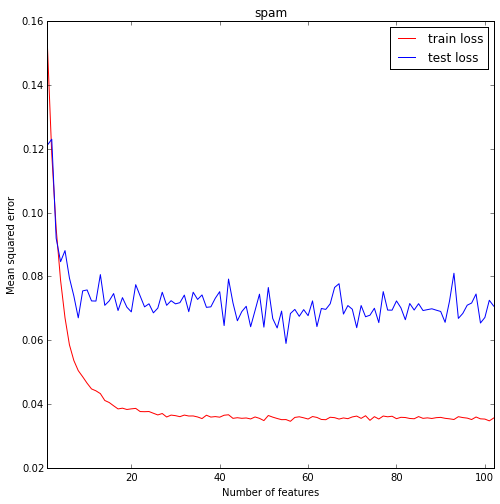

In [7]:
pl.figure(figsize=(8, 8))

N = X_train.shape[1]
t = np.linspace(1, N, N, endpoint=True)

train, = pl.plot(t, mse_train, color="red", linewidth=1.0, linestyle="-")
test, = pl.plot(t, mse_test, color="blue", linewidth=1.0, linestyle="-")
pl.xlim(1, N)
pl.title("spam")
pl.legend([train, test], ['train loss', 'test loss'])
pl.xlabel("Number of features")
pl.ylabel("Mean squared error")

pl.show()

# Check on sklearn regressor

In [13]:
model_sk = ensemble.GradientBoostingRegressor(**params)
model_sk.fit(X_train, Y_train)
mse_sklearn = mean_squared_error(model_sk.predict(X_test), Y_test)
print "MSE on %d features:\t%0.10f" % (X_train.shape[1], mse_sklearn)

X_train_small = X_train[:, indices[:8]]
X_test_small = X_test[:, indices[:8]]

model_sk_small = ensemble.GradientBoostingRegressor(**params)
model_sk_small.fit(X_train_small, Y_train)
mse_sklearn_small = mean_squared_error(model_sk_small.predict(X_test_small), Y_test)
print "MSE on %d features:\t%0.10f" % (X_train_small.shape[1], mse_sklearn_small)

MSE on 102 features:	0.0736479318
MSE on 8 features:	0.0670077441


# Visualize importance of every feature

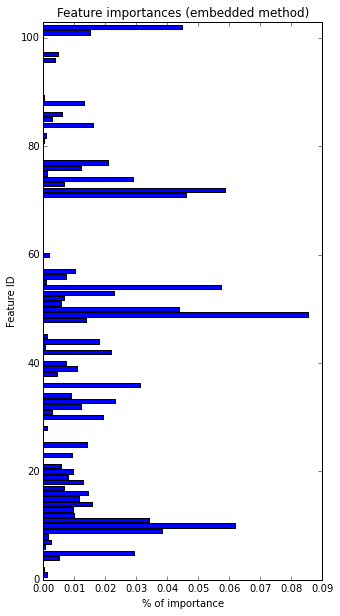

In [20]:
pl.figure(figsize=(5, 10))

pl.barh(t, model.feature_importances, align='center')
pl.ylim(0, N + 1)
pl.title("Feature importances (embedded method)")
pl.xlabel("% of importance")
pl.ylabel("Feature ID")

pl.show()